In [218]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import pickle
from umap import UMAP
import numpy as np
from sklearn.decomposition import PCA


class Languages:
    si = 'SI'
    gb = 'GB'
    hu = 'HU'
    ua = 'UA'
    all = [si, gb, hu, ua]
plot_artefacts = Path('artefacts/plots')

In [4]:
topic_artefacts = Path('artefacts/by_topic/topic_csvs')
embedding_artefacts_base = Path('artefacts/bojan')
embedding_artefacts = {
    Languages.si: pickle.load(open(embedding_artefacts_base / 'ParlaMint_SI_embeddings_truncated.pkl', 'rb')),
    Languages.gb: pickle.load(open(embedding_artefacts_base / 'ParlaMint_GB_commons_embeddings_truncated.pkl', 'rb')),
    Languages.ua: pickle.load(open(embedding_artefacts_base / 'ParlaMint_UA_embeddings_truncated.pkl', 'rb')),
    Languages.hu: pickle.load(open(embedding_artefacts_base / 'ParlaMint_HU_embeddings_truncated.pkl', 'rb')),
}

In [162]:
topic_names = ['war', 'eu', 'healthcare', 'gender']
topics = {
    t: {
        l: pd.read_csv(topic_artefacts / f'{t}_{l}.csv') for l in tqdm(embedding_artefacts)
    } for t in topic_names
}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.68it/s]


In [164]:
def get_embeddings_for_speaker(embeddings, speech_ids):
    return np.average([embeddings[sid] for sid in speech_ids if sid in embeddings], axis=0)

In [195]:
lang = Languages.gb
topic_df = topics['war'][lang]


def get_color_for_party(party):
    if party == 'LAB':
        return 'blue'
    elif party == 'CON':
        return 'red'
    else:
        return 'white'


embeddings_subset = []
colors = []
for speaker_name, speaker_group in topic_df.groupby('Speaker_name'):
    embeddings_subset.append(get_embeddings_for_speaker(embedding_artefacts[lang], speaker_group.ID.values))
    sample = next(speaker_group.iterrows())[1]
    colors.append(get_color_for_party(sample.Speaker_party))
len(embeddings_subset)

894

In [208]:
parties = []
for party, subc in topics['war'][Languages.ua].groupby('Speaker_party'):
    parties.append((party, len(subc)))
for p in sorted(parties, key=lambda x: x[1], reverse=True):
    print(p)


('фВОБ', 944)
('фБПП', 627)
('фНФ', 608)
('фЛяшко', 588)
('фЄС', 565)
('фСН', 371)
('фОС', 325)
('фПГ', 298)
('фОПЗЖ', 233)
('фСвобода', 216)
('гДовіра', 193)
('фОпоблок', 193)
('гЗМП', 177)
('фУДАР', 118)
('фПР', 75)
('гСЄУ', 55)
('гЕР', 52)
('гВН', 46)
('гПВ', 32)
('НФ', 25)
('гЗМіС', 25)
('БПП', 15)
('Свобода', 12)
('фКПУ', 4)
('УСГ', 3)
('фОпоблок;фОПЗЖ', 3)
('фБЮТ', 2)
('фБПП;фЄС', 1)
('фНФ;фЄС', 1)


In [205]:
for party, subc in topics['war'][Languages.hu].groupby('Speaker_party'):
    print(party, len(subc))

DK 5
DK-frakció 130
EGYÜTT 1
Fidesz 4
Fidesz-frakció 689
JOBBIK-frakció 460
KNDP-frakció 282
LMP 3
LMP-frakció 141
MLP 4
MNOÖ 2
MSZP 3
MSZP-frakció 301
Mi Hazánk 4
Mi Hazánk-frakció 10
Momentum-frakció 13
Párbeszéd 3
Párbeszéd-frakció 38
Szolidaritás 2
Volner 1


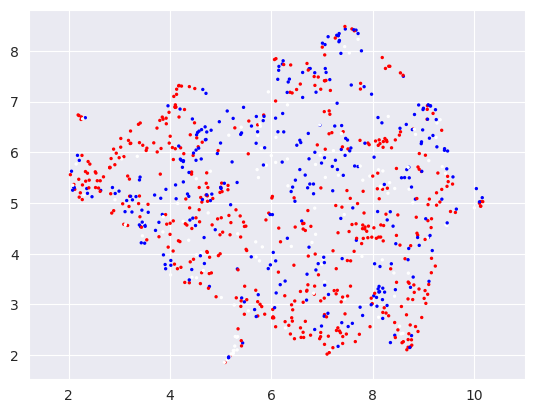

In [196]:
reducer = UMAP(n_neighbors=5,
               min_dist=0.1,
               n_components=2,
               metric='euclidean')
reduced_embeddings = reducer.fit_transform(embeddings_subset)
plt.cla()
plt.clf()
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=colors,
    s=2,
)
plt.gca().set_aspect('equal', 'datalim')

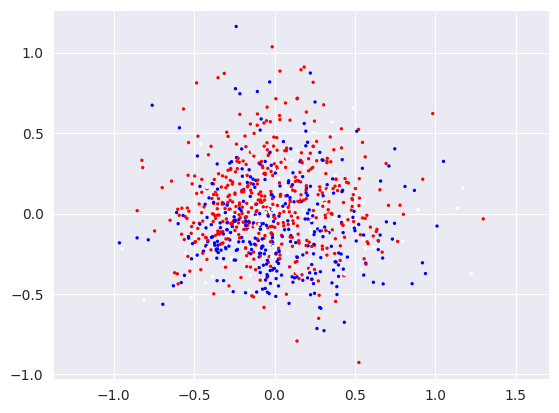

In [197]:
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_subset)

plt.cla()
plt.clf()
plt.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    c=colors,
    s=2,
)
plt.gca().set_aspect('equal', 'datalim')

# Polarization grid

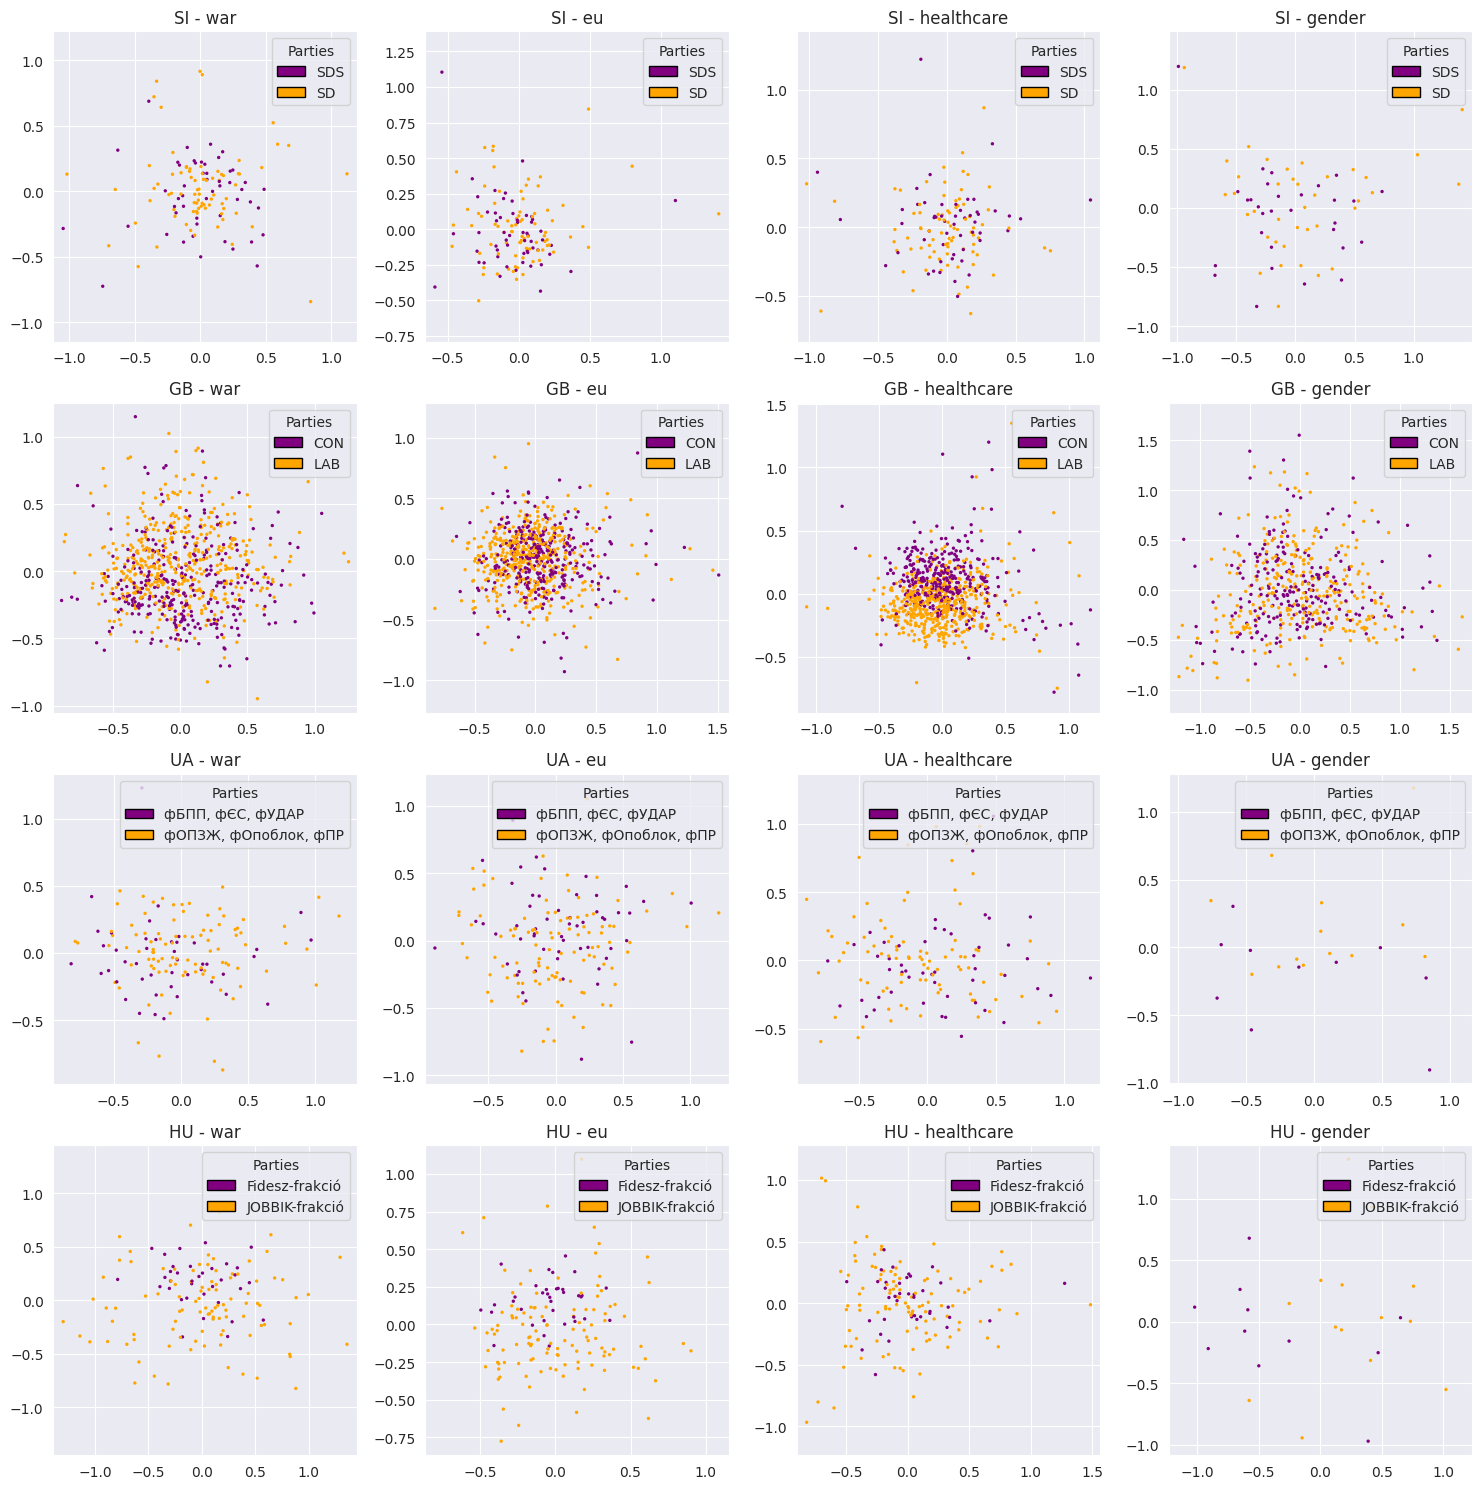

In [219]:
from matplotlib.patches import Patch

c1 = 'purple'
c2 = 'orange'

party_combinations = {
    Languages.si: (('SDS',), ('SD',)),
    Languages.gb: (('CON',), ('LAB',)),
    Languages.ua: (('фБПП', 'фЄС', 'фУДАР'), ('фОПЗЖ', 'фОпоблок', 'фПР')),
    Languages.hu: (('Fidesz-frakció',), ('JOBBIK-frakció',)),
}

fig, axs = plt.subplots(4, 4, figsize=(15, 15))  # Prepare a 4x4 grid of subplots

# Iterate over each language
for i, (lang, parties) in enumerate(party_combinations.items()):
    # Iterate over each topic
    for j, topic in enumerate(topic_names):
        topic_df = topics[topic][lang]
        embeddings_subset = []
        colors = []
        legend = [(', '.join(parties[0]), c1), (', '.join(parties[1]), c2)]

        # Only include data for specified parties
        topic_df = topic_df[topic_df['Speaker_party'].isin(parties[0] + parties[1])]
        for speaker_name, speaker_group in topic_df.groupby('Speaker_name'):
            embeddings_subset.append(get_embeddings_for_speaker(embedding_artefacts[lang], speaker_group.ID.values))
            sample = next(speaker_group.iterrows())[1]
            if sample.Speaker_party in parties[0]:
                colors.append('Orange')
            elif sample.Speaker_party in parties[1]:
                colors.append('purple')
            else:
                colors.append('white')

        pca = PCA(n_components=2)
        reduced_embeddings = pca.fit_transform(embeddings_subset)

        # Plot the results on a subplot
        axs[i][j].scatter(
            reduced_embeddings[:, 0],
            reduced_embeddings[:, 1],
            c=colors,
            s=2,
        )
        axs[i][j].set_aspect('equal', 'datalim')
        axs[i][j].set_title(f'{lang} - {topic}')  # Add a title to each subplot

        # Create legend
        legend_elements = [Patch(facecolor=c, edgecolor='black', label=party) for party, c in legend]
        axs[i][j].legend(handles=legend_elements, title='Parties', loc='upper right')

plt.tight_layout()  # Adjust subplot parameters to give specified padding
plt.savefig(plot_artefacts / 'polarization_grid.png', dpi=300)
plt.show()  # Display the figure